In [1]:
import sys
sys.path.append("../")
import numpy as np
from scipy.fftpack import fftfreq
import os
import glob
import csv
from utils import show_peak, FFTStrip, doubleplot, doFilterFFT, VelocityStrip, watershed_image_hough,DiffVelocityStrip
import pandas as pd
from tifffile import imread, imwrite
from scipy.fftpack import fft

import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_erosion
from bokeh.plotting import figure, output_file, show
from bokeh.io import export_png, output_notebook
from scipy.signal import find_peaks
from skimage import data, io
from bokeh.models import Label
from skimage.filters import threshold_otsu, threshold_mean
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile

In [4]:
sourcedirKymo = '/Users/aimachine/DarineKymo/'
savedir = sourcedirKymo + 'Results/'
Time_unit = 10
Xcalibration = 0.034
blocksize = 50
ignorelast = 5


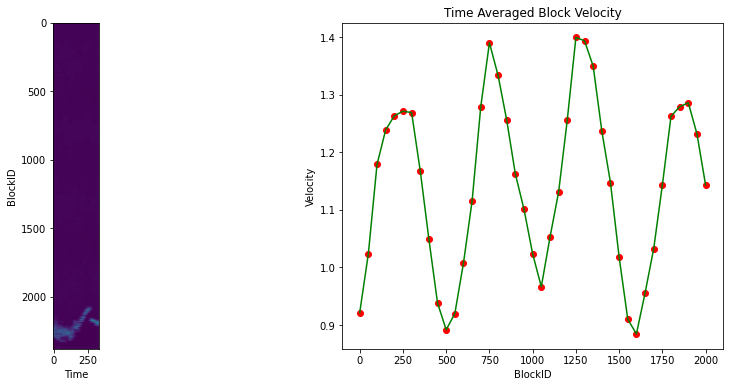

Anterior Part :  1.1390655634987572 Posterior Part : 1.1478346322429485


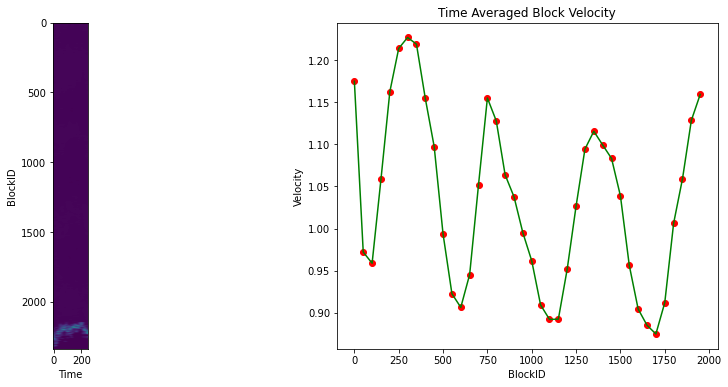

Anterior Part :  1.0718245139203728 Posterior Part : 0.9975219738229868


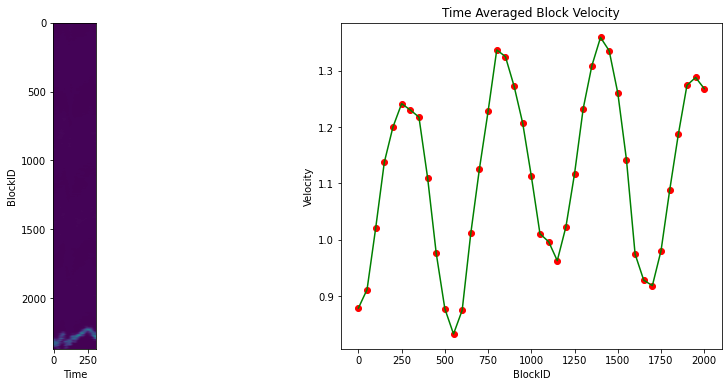

Anterior Part :  1.1008948068662998 Posterior Part : 1.131861481756567


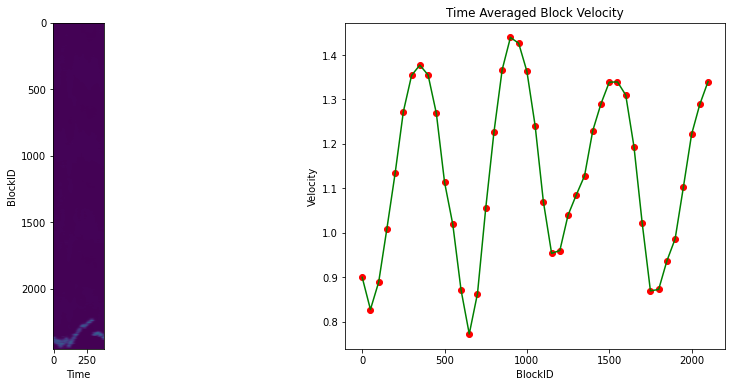

Anterior Part :  1.138559442242069 Posterior Part : 1.128428749838533


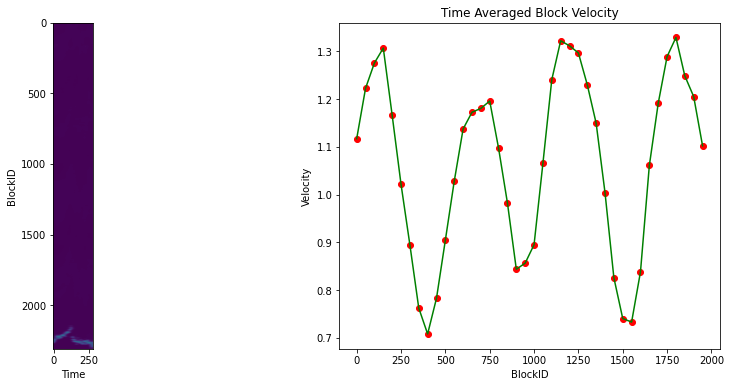

Anterior Part :  1.0327344344105007 Posterior Part : 1.1038639740556906


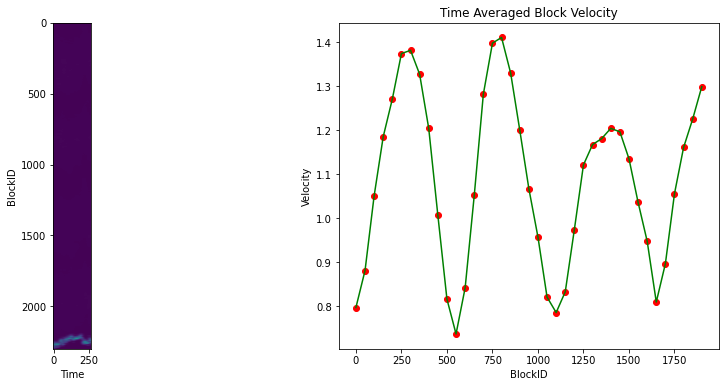

Anterior Part :  1.1337271419488304 Posterior Part : 1.0434291605964527


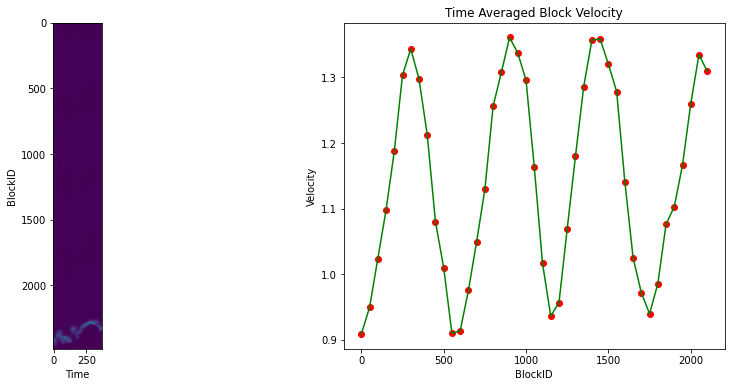

Anterior Part :  1.1404890744880207 Posterior Part : 1.147048242428745


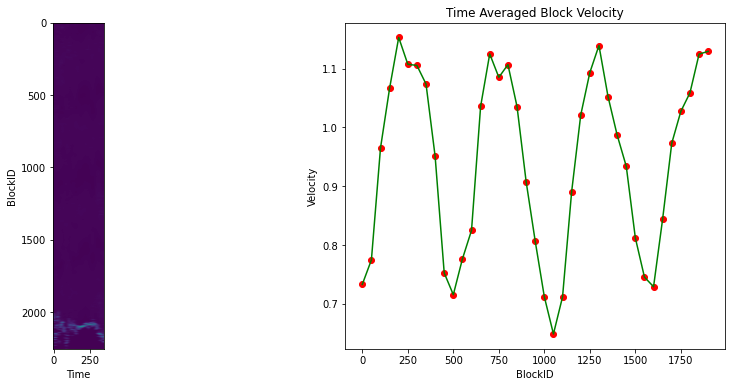

Anterior Part :  0.962905268230161 Posterior Part : 0.9220092524654715


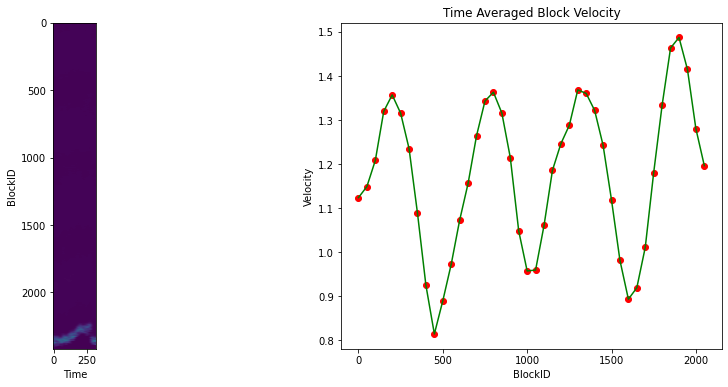

Anterior Part :  1.1490296007492924 Posterior Part : 1.2052709245111413


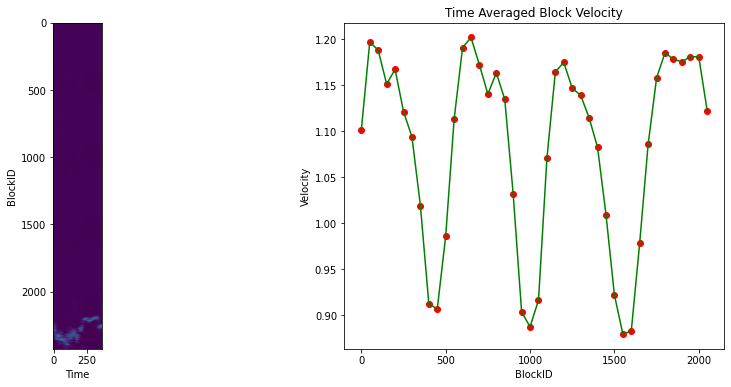

Anterior Part :  1.0848557810667967 Posterior Part : 1.083221424922687


,Anterior Part,Posterior Part
DistanceMethodCurvature_Dpachys6_RAWTrackID1,1.139066,1.147835
DistanceMethodCurvature_Dpa_05_RAWAdjustedTrackID1,1.071825,0.997522
DistanceMethodCurvature_Dpachys_13-adjustedTrackID1,1.100895,1.131861
DistanceMethodCurvature_Dpachys_08-adjustedTrackID1,1.138559,1.128429
DistanceMethodCurvature_Dpachys_12_tempTrackID1,1.032734,1.103864
DistanceMethodCurvature_Dpachys_15-adjustedTrackID1,1.133727,1.043429
DistanceMethodCurvature_Dpachys_10-adjustedTrackID1,1.140489,1.147048
DistanceMethodCurvature_registered embryoTrackID1,0.962905,0.922009
DistanceMethodCurvature_Dpachys_14-adjustedTrackID1,1.149030,1.205271
DistanceMethodCurvature_Dpachys_11-adjustedTrackID1,1.084856,1.083221


In [5]:
Raw_path = os.path.join(sourcedirKymo, '*tif')
X = glob.glob(Raw_path)
Path(savedir).mkdir(exist_ok = True)
AverageVelocity = []
Block = []
AverageFrequ = []
Frequency = []
ImageName = []
AnteriorList = []
PosteriorList = []
for fname in X:
    image = imread(fname)
    #image = np.swapaxes(image,0,1)
    #X axis should be time
  
    Name = os.path.basename(os.path.splitext(fname)[0])

    #Get simple velocity

    ImageName.append(Name)
    diffImage = VelocityStrip(image,blocksize,Xcalibration)
    BlockVelocity = DiffVelocityStrip(diffImage, blocksize, Xcalibration)
    imwrite((savedir + Name + '.tif' ) , diffImage.astype('float32'))
    IndexList = []
    VelocityList = []
    for i in range(0, len(BlockVelocity) -ignorelast):
        
        index, velocity = BlockVelocity[i]
        IndexList.append(index)
        VelocityList.append(velocity)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(diffImage)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('BlockID')
    ax[1].plot(IndexList, VelocityList, 'ro')
    ax[1].plot(IndexList, VelocityList, 'g')
    ax[1].set_title('Time Averaged Block Velocity')
    ax[1].set_xlabel('BlockID')
    ax[1].set_ylabel('Velocity')
    plt.show()
    df = pd.DataFrame(list(zip(VelocityList,IndexList)), columns =['Velocity', 'BlockIndex'])
    df.to_csv(savedir + Name + "SimpleVelocity"  '.csv', index = False)  
         
    Anterior =    VelocityList[:len(VelocityList)//2]
    Posterior = VelocityList[len(VelocityList)//2:]
    AnteriorList.append(np.mean(Anterior))
    PosteriorList.append(np.mean(Posterior))
    print('Anterior Part : ', np.mean(Anterior), 'Posterior Part :', np.mean(Posterior))
df = pd.DataFrame(list(zip(AnteriorList,PosteriorList)),index = ImageName, columns =['Anterior Part', 'Posterior Part'])
df.to_csv(savedir + Name + "AnteriorPosterior"  '.csv', index = False)   
df
    